Author: Athénaïs Vaginay (vaginay.athenais@gmail.com)
The latest version of this IPython notebook is available at https://github.com/Athenais/graph-clustering-for-protein-peeling.

In [8]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib notebook 
#% matplotlib inline 
import matplotlib.pyplot as plt

In [9]:
pdb_code = "1mbs"
pdb_dir = "test"

In [10]:
from Bio import PDB

pdbl = PDB.PDBList()
pdb_path =  pdbl.retrieve_pdb_file(pdb_code, pdir = pdb_dir)

Structure exists: 'test/pdb1mbs.ent' 


In [11]:

parser = PDB.PDBParser()

# Parse the structure into a PDB.Structure object
struct = parser.get_structure(pdb_code, pdb_path)


In [12]:
print struct.header # dict with header infos

{'structure_method': 'x-ray diffraction', 'head': 'oxygen transport', 'journal': 'AUTH   H.SCOULOUDI,E.N.BAKERTITL   X-RAY CRYSTALLOGRAPHIC STUDIES OF SEAL MYOGLOBIN.TITL 2 THE MOLECULE AT 2.5 A RESOLUTION.REF    J.MOL.BIOL.                   V. 126   637 1978REFN                   ISSN 0022-2836PMID   745243DOI    10.1016/0022-2836(78)90013-X', 'journal_reference': 'h.scouloudi,e.n.baker x-ray crystallographic studies of seal myoglobin. the molecule at 2.5 a resolution. j.mol.biol. v. 126 637 1978 issn 0022-2836 745243 10.1016/0022-2836(78)90013-x ', 'compound': {'1': {'molecule': 'myoglobin', 'misc': '', 'engineered': 'yes', 'chain': 'a'}}, 'keywords': 'oxygen transport', 'name': ' x-ray crystallographic studies of seal myoglobin. the molecule at 2.5 angstroms resolution', 'author': 'H.Scouloudi', 'deposition_date': '1979-03-22', 'release_date': '1979-05-15', 'source': {'1': {'organism_common': 'harbor seal', 'misc': '', 'organism_taxid': '9720', 'organism_scientific': 'phoca vitulin

In [13]:

points = []

# get Calpha of not hetero res : 
for residue in struct.get_residues():
    tags = residue.get_full_id()
    print tags,
    # tags contains a tuple with (Structure ID, Model ID, Chain ID, (Residue ID))
    # Residue ID is a tuple with (*Hetero Field*, Residue ID, Insertion Code)
    # Thus *Hetero Field*, is empty (tags[3][0] != " ") if the residue is not a hetero atom 
    # or have some flag if it is 
    #   W for waters, 
    #   H for hetero res (e.g. 'H_GLC' in the case of a glucose molecule), 
    #   etc.
    # hetero atoms do not have CA
    try :    
        print residue['CA'].get_coord() 
        points.append(  residue['CA'].get_coord()) 
    except KeyError : 
        print 'Key Error -> can t access CA coord of hetero atom :'  
        print tags[3][0] # flag of the hetero atom


('1mbs', 0, 'A', (' ', 1, ' ')) [ 15.23400021  10.46199989 -10.55599976]
('1mbs', 0, 'A', (' ', 2, ' ')) [ 16.8029995    8.16399956  -7.99399996]
('1mbs', 0, 'A', (' ', 3, ' ')) [ 18.41600037   6.40399981 -10.97200012]
('1mbs', 0, 'A', (' ', 4, ' ')) [ 21.26799965   3.95300007 -11.27600002]
('1mbs', 0, 'A', (' ', 5, ' ')) [ 23.875        6.16599989  -9.59399986]
('1mbs', 0, 'A', (' ', 6, ' ')) [ 21.54500008   7.09000015  -6.7420001 ]
('1mbs', 0, 'A', (' ', 7, ' ')) [ 20.45400047   3.477       -6.29799986]
('1mbs', 0, 'A', (' ', 8, ' ')) [ 24.01399994   2.11899996  -6.28000021]
('1mbs', 0, 'A', (' ', 9, ' ')) [ 25.06699944   4.796       -3.82599998]
('1mbs', 0, 'A', (' ', 10, ' ')) [ 22.21299934   4.03999996  -1.41400003]
('1mbs', 0, 'A', (' ', 11, ' ')) [ 22.74500084   0.294       -1.75699997]
('1mbs', 0, 'A', (' ', 12, ' ')) [ 26.49900055   0.537       -1.09599996]
('1mbs', 0, 'A', (' ', 13, ' ')) [ 26.20400047   2.97799993   1.79900002]
('1mbs', 0, 'A', (' ', 14, ' ')) [ 23.56200027 

<IPython.core.display.Javascript object>


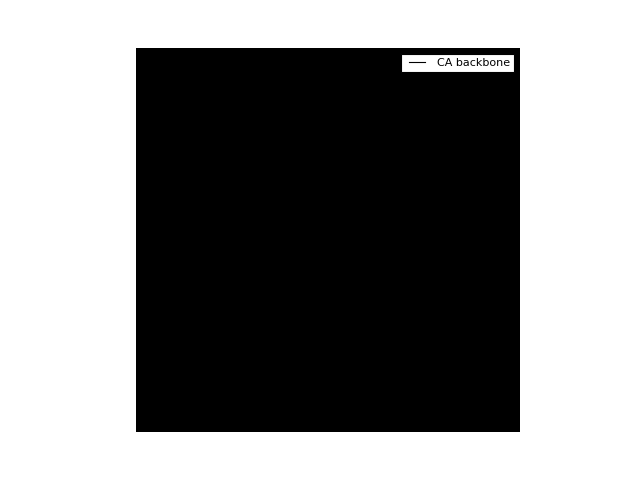

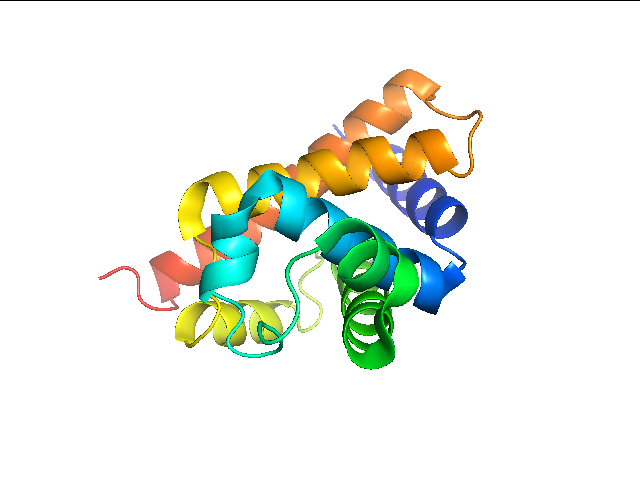

In [33]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

points = np.array(points)
x = points[:, 0] # or  zip(*points)[0] if no np array
y = points[:, 1]
z = points[:, 2]

ax.plot(x, y, z, label='CA backbone' , color='black' )
ax.scatter(x, y, z,  s=20, c=plt.cm.rainbow(xrange (len (points) )  ))

ax.legend()



plt.show()






cmd_visu_prot = "pymol -ix {0}  visualize-as-cartoon_spectrum.pml -g img/visu_prot_{1}.png".format(pdb_path, pdb_code)
# -i -> Disable the internal OpenGL GUI (object list, menus, etc.) 
# -x -> Disable the external GUI module.
# -g -> Write a PNG file (after evaluating previous arguments) 
subprocess.call(shlex.split(cmd_visu_prot))

from IPython.display import Image
Image("img/visu_prot_{0}.png".format(pdb_code) )


In [16]:
import scipy.spatial.distance

dist_condensed = scipy.spatial.distance.pdist(points, 'euclidean') 
# numpy array : values from triangle matrix without diagonal 

print dist_condensed

[ 3.78238117  5.17354289  8.90475313 ...,  3.80814971  5.52240917
  3.80346236]


<IPython.core.display.Javascript object>


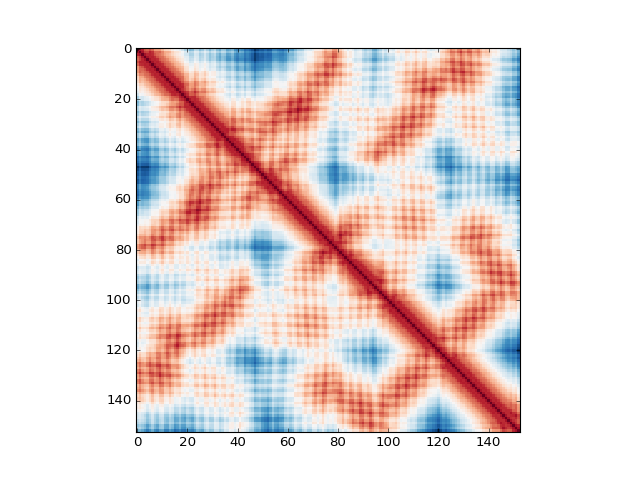

In [17]:
plt.figure()

dist = scipy.spatial.distance.squareform(dist_condensed)
plt.imshow(dist, cmap='RdBu', interpolation='None')


plt.show()

In [18]:

d0 = 8  # cutoff fixed to 8 in ref art

# Boolean matrix C in which the element C(i,j) equals 1 if the inter-C a distance d(i,j) 
# between the ith and jth Ca of the protein backbone is less than a cut-off d0.
C_condensed = dist_condensed < d0 

<IPython.core.display.Javascript object>


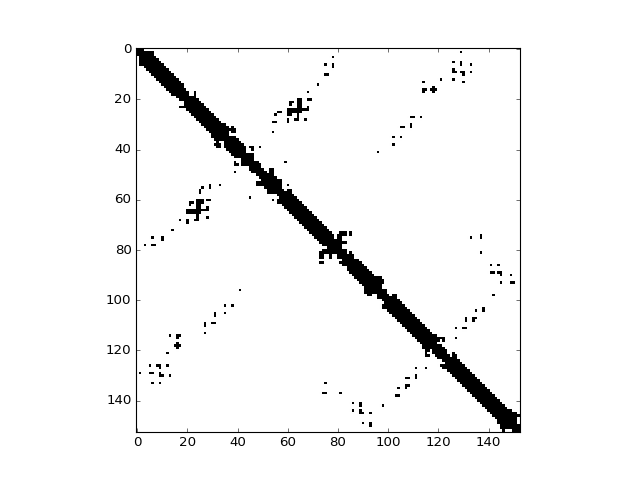

In [19]:
#plot contact matrix : 

plt.figure()

C_dec = scipy.spatial.distance.squareform(C_condensed, force='no', checks=False)
np.fill_diagonal(C_dec, 1)

plt.imshow(C_dec, cmap='Greys', interpolation='None')
plt.show()

Use a logistic transformation to have continuous values  instead  of  Boolean  values from the adjacency C matrix : 

In [20]:
d0 = 8
delta  = 1.5   

import numpy as np
P_condensed =   1   / (  1 + np.exp(  (dist_condensed - d0)  / delta ) ) 

In [35]:
assert (  ( P_condensed >= 0).all() and (P_condensed <= 1).all()  )

<IPython.core.display.Javascript object>


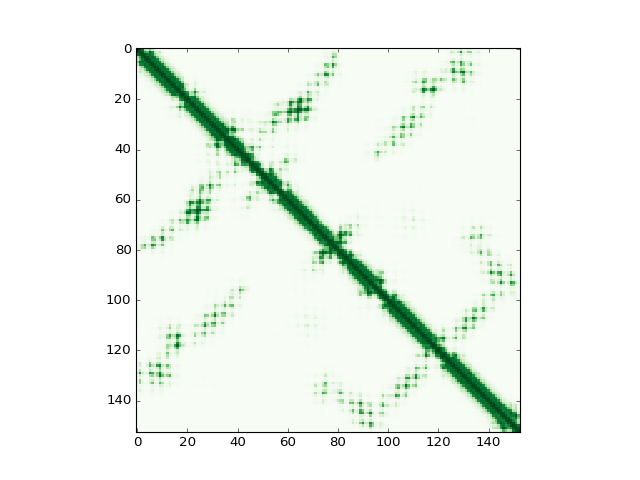

In [38]:
P = scipy.spatial.distance.squareform(P_condensed, force='no', checks=False)
np.fill_diagonal(P, 1)


plt.figure()
plt.imshow(P, cmap='Greens', interpolation='None')
plt.show()

# Apply MCL algorithm

Use code from http://micans.org/mcl/

In [23]:
with open('P_'+pdb_code+'.abc', "w") as abc_out : 
	abc_out.write("# P matrix from "+pdb_code+"\n")
	for i, line in enumerate (P) : 
		for j, col in enumerate (line) : 
			abc_out.write( '{0} {1} {2}\n'.format(i, j, P[i, j])  ) 


In [24]:
import subprocess
import shlex 


# convert abc format in mcl suite native format : 
cmd_mcxload = "mcxload -abc {0}.abc --stream-mirror -write-tab {0}.tab -o {0}.mci".format('P_'+pdb_code) 
subprocess.call(shlex.split(cmd_mcxload))
    

0

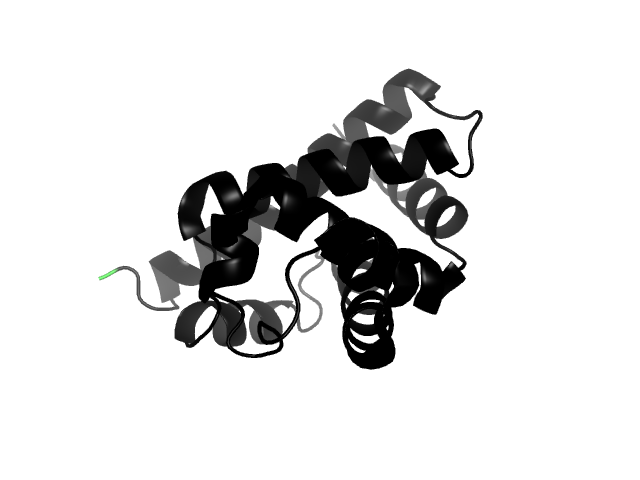

i = 0.04 , nb_cluster = 1 : 
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]]


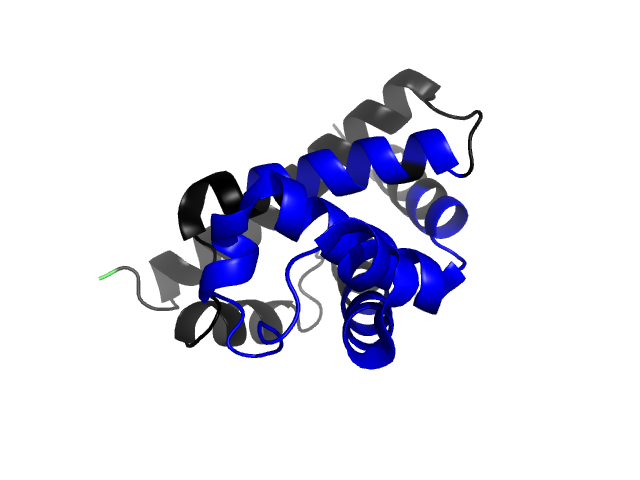

i = 1.4 , nb_cluster = 2 : 
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 115, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118]]


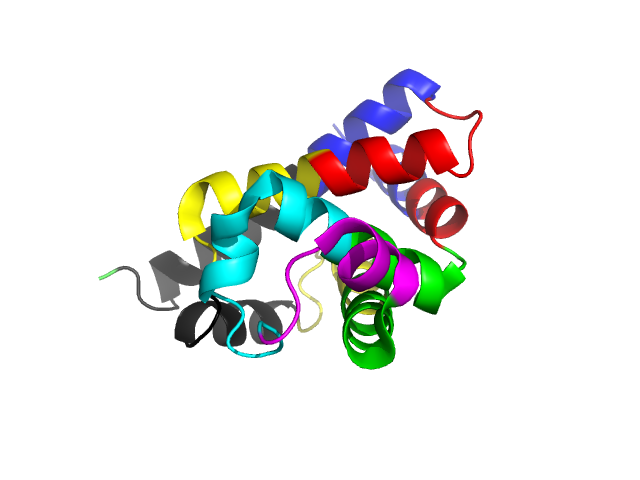

i = 2 , nb_cluster = 8 : 
[[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [12, 13, 14, 15, 16, 17, 18, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]]


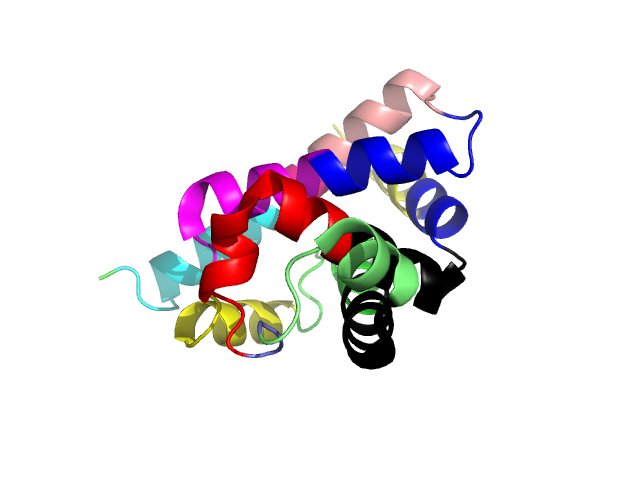

i = 3 , nb_cluster = 13 : 
[[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [12, 13, 14, 15, 16, 17, 18, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57], [45, 46, 47], [134, 135, 136], [137, 138]]


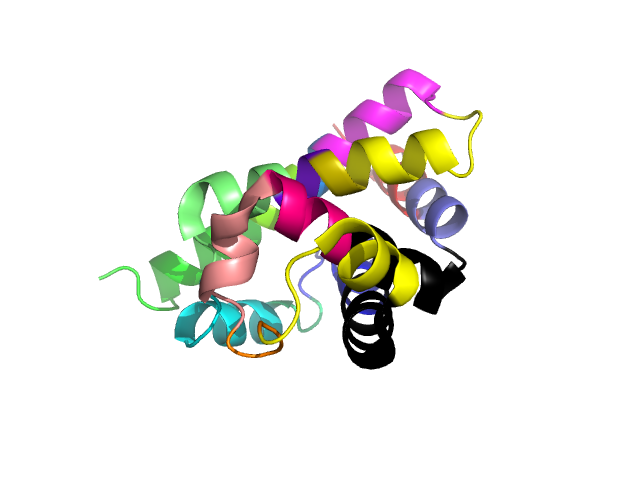

i = 4 , nb_cluster = 18 : 
[[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57], [123, 124, 125, 126, 127, 128, 129, 130, 131, 132], [36, 37, 38, 39, 40, 41, 42, 43], [99, 100, 101, 102, 103, 104, 105, 106], [12, 13, 14, 15, 16, 17, 18], [29, 30, 31, 32, 33, 34, 35], [44, 45, 46, 47], [136, 137, 138, 139], [84, 85, 86], [107, 108, 109], [133, 134, 135], [110, 111]]


In [59]:
cmd_mcl_tpl = 'mcl {0}.mci -I %f'.format('P_'+pdb_code)


i_values  = [0.04, 1.4, 2, 3, 4]


clusters_definition = dict()
# clusters_definition[i_value][cluster_id] = [ list of cluster member]


for i_value in i_values :
    clusters_definition [i_value]= list()
    subprocess.call(shlex.split(cmd_mcl_tpl % i_value))
    
    i_string = "{0:03.1f}".format(i_value).replace('.', '')
    cluster_filename = "out.P_{0}.mci.I{1}".format (pdb_code,   i_string ) 
    
    
      
    cmd_visu_prot = "pymol -c {0}   visualize-clusters.pml -- {1}  img/  ".format(
        pdb_path, cluster_filename)
    # -c -> Command line mode, no GUI. For batch operations.  
    subprocess.call(shlex.split(cmd_visu_prot))


    with open(cluster_filename, 'r') as cluster_file:        
        
        clusters_definitions = False
        # False while 'begin' tag is not reached
        # then True during cluster definition 
        # then False after cluster definition (when tag ')' is not reached ) 
        
        for line in cluster_file:
            if line == "begin\n": 
                clusters_definitions = True
            elif line == ")\n": 
                clusters_definitions = False
            elif clusters_definitions:  # now we are in clusters definition : 
                
                    if line[0].isdigit() : # begin of a cluster definition 
                        #rm the cluster id from the line so it won't be assign as cluster members
                        cluster_id, line = line.split(' ', 1)
                        cluster_members = []                        
                    
                    #line contains only members (cluster id was previously removed)
                    cluster_members.extend (line.split()) 
                    
                    if cluster_members[-1] == "$":  #end of cluster definition 
                        cluster_members = [int (member) for member in cluster_members[:-1] ] #-1 : '$' tag
                        clusters_definition[i_value].append(cluster_members)
    
    from IPython.display import display, Image
    display(Image(filename="img/{0}.png".format(cluster_filename), retina=True))
    
    print "i = {0} , nb_cluster = {1} : \n{2}".format (i_value, len(clusters_definition[i_value]), clusters_definition[i_value])
